In [1]:
import os
from datasets import load_dataset
import sqlite3
import pandas as pd
import torch
import json
from transformers import RobertaTokenizer
from modules.models import CodeBertJS,CodeT5
from modules.datasets import CodeBertDataset
from modules.metrics import CodeRouge
from torch.utils.data import DataLoader

# SQLITE_PATH = input("Paste sqlite3 path: ")
# MODEL_NAME = input("Paste Model Name: ")
# VERSION = int(input("Paste model version: "))
# CPKT_PATH = input('Paste cpkt path: ')
# METRICS_PATH = input('Paste metris dir path: ')
# HF_DIR = input('Paste hf model dir')
# MAX_LENGTH = int(input("Paste tokenizer max length: "))

SQLITE_PATH =  'humanevalpack.db'
MODEL_NAME = 'CodeBertJS'
VERSION = 5
CPKT_PATH = 'checkpoints/CodeBertJS_v5.ckpt'
METRICS_PATH = 'metrics'
HF_DIR = 'microsoft/codebert-base-mlm'
MAX_LENGTH = 475

In [2]:
if os.path.exists(SQLITE_PATH):
    con = sqlite3.connect(SQLITE_PATH)
    ds_df = pd.read_sql_query("SELECT * FROM humanevalpack", con).set_index('index')
else:
    ds = load_dataset(
        'bigcode/humanevalpack',
        'js',
    )
    ds_list = []
    for row in ds.get('test'):
        ds_list.append(row)
    ds_df = pd.DataFrame(ds_list)
    con = sqlite3.connect(SQLITE_PATH)
    ds_df.to_sql('humanevalpack',con)


In [3]:
if MODEL_NAME == 'T5JSRephraser':
    model = CodeT5.load_from_checkpoint(CPKT_PATH)
elif 'CodeBertJS' in MODEL_NAME:
    model = CodeBertJS.load_from_checkpoint(CPKT_PATH)
    
if model.device != 'cpu':
    model.to('cpu')

model.mode = 'test'

/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.2, which is newer than your current Lightning version: v2.2.1
Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
tokenizer = RobertaTokenizer.from_pretrained(HF_DIR)
encoded_samples = tokenizer(
    ds_df['buggy_solution'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = tokenizer(
    ds_df['canonical_solution'].tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

In [5]:
torch_ds = CodeBertDataset(encoded_samples, encoded_labels.input_ids)
loader = DataLoader(torch_ds, batch_size=1)

generated_codes = []
for batch in iter(loader):
    out = model.forward(**batch)
    decoded_out = torch.argmax(out[1], dim=-1)
    generated_codes.append(tokenizer.batch_decode(decoded_out, skip_special_tokens=True)[0])
    
references = ds_df['canonical_solution'].tolist()

if(len(generated_codes) != len(references)):
    raise ValueError("Invalid model output.")

In [6]:
rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=generated_codes, references=references)
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}.csv"
with open(avgs_path, 'w') as f:
    json.dump(rouge.avgs, f)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index='table')

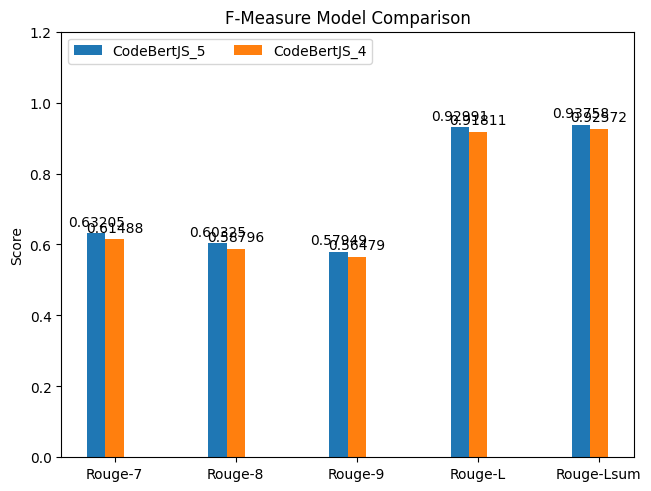

In [24]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-1].split('.')[0]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)
    

plot_data = {
    f"{MODEL_NAME}_{VERSION}": (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')


for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
plt.show()

<Axes: title={'center': 'F-Measure Model Comparison'}, ylabel='Score'>

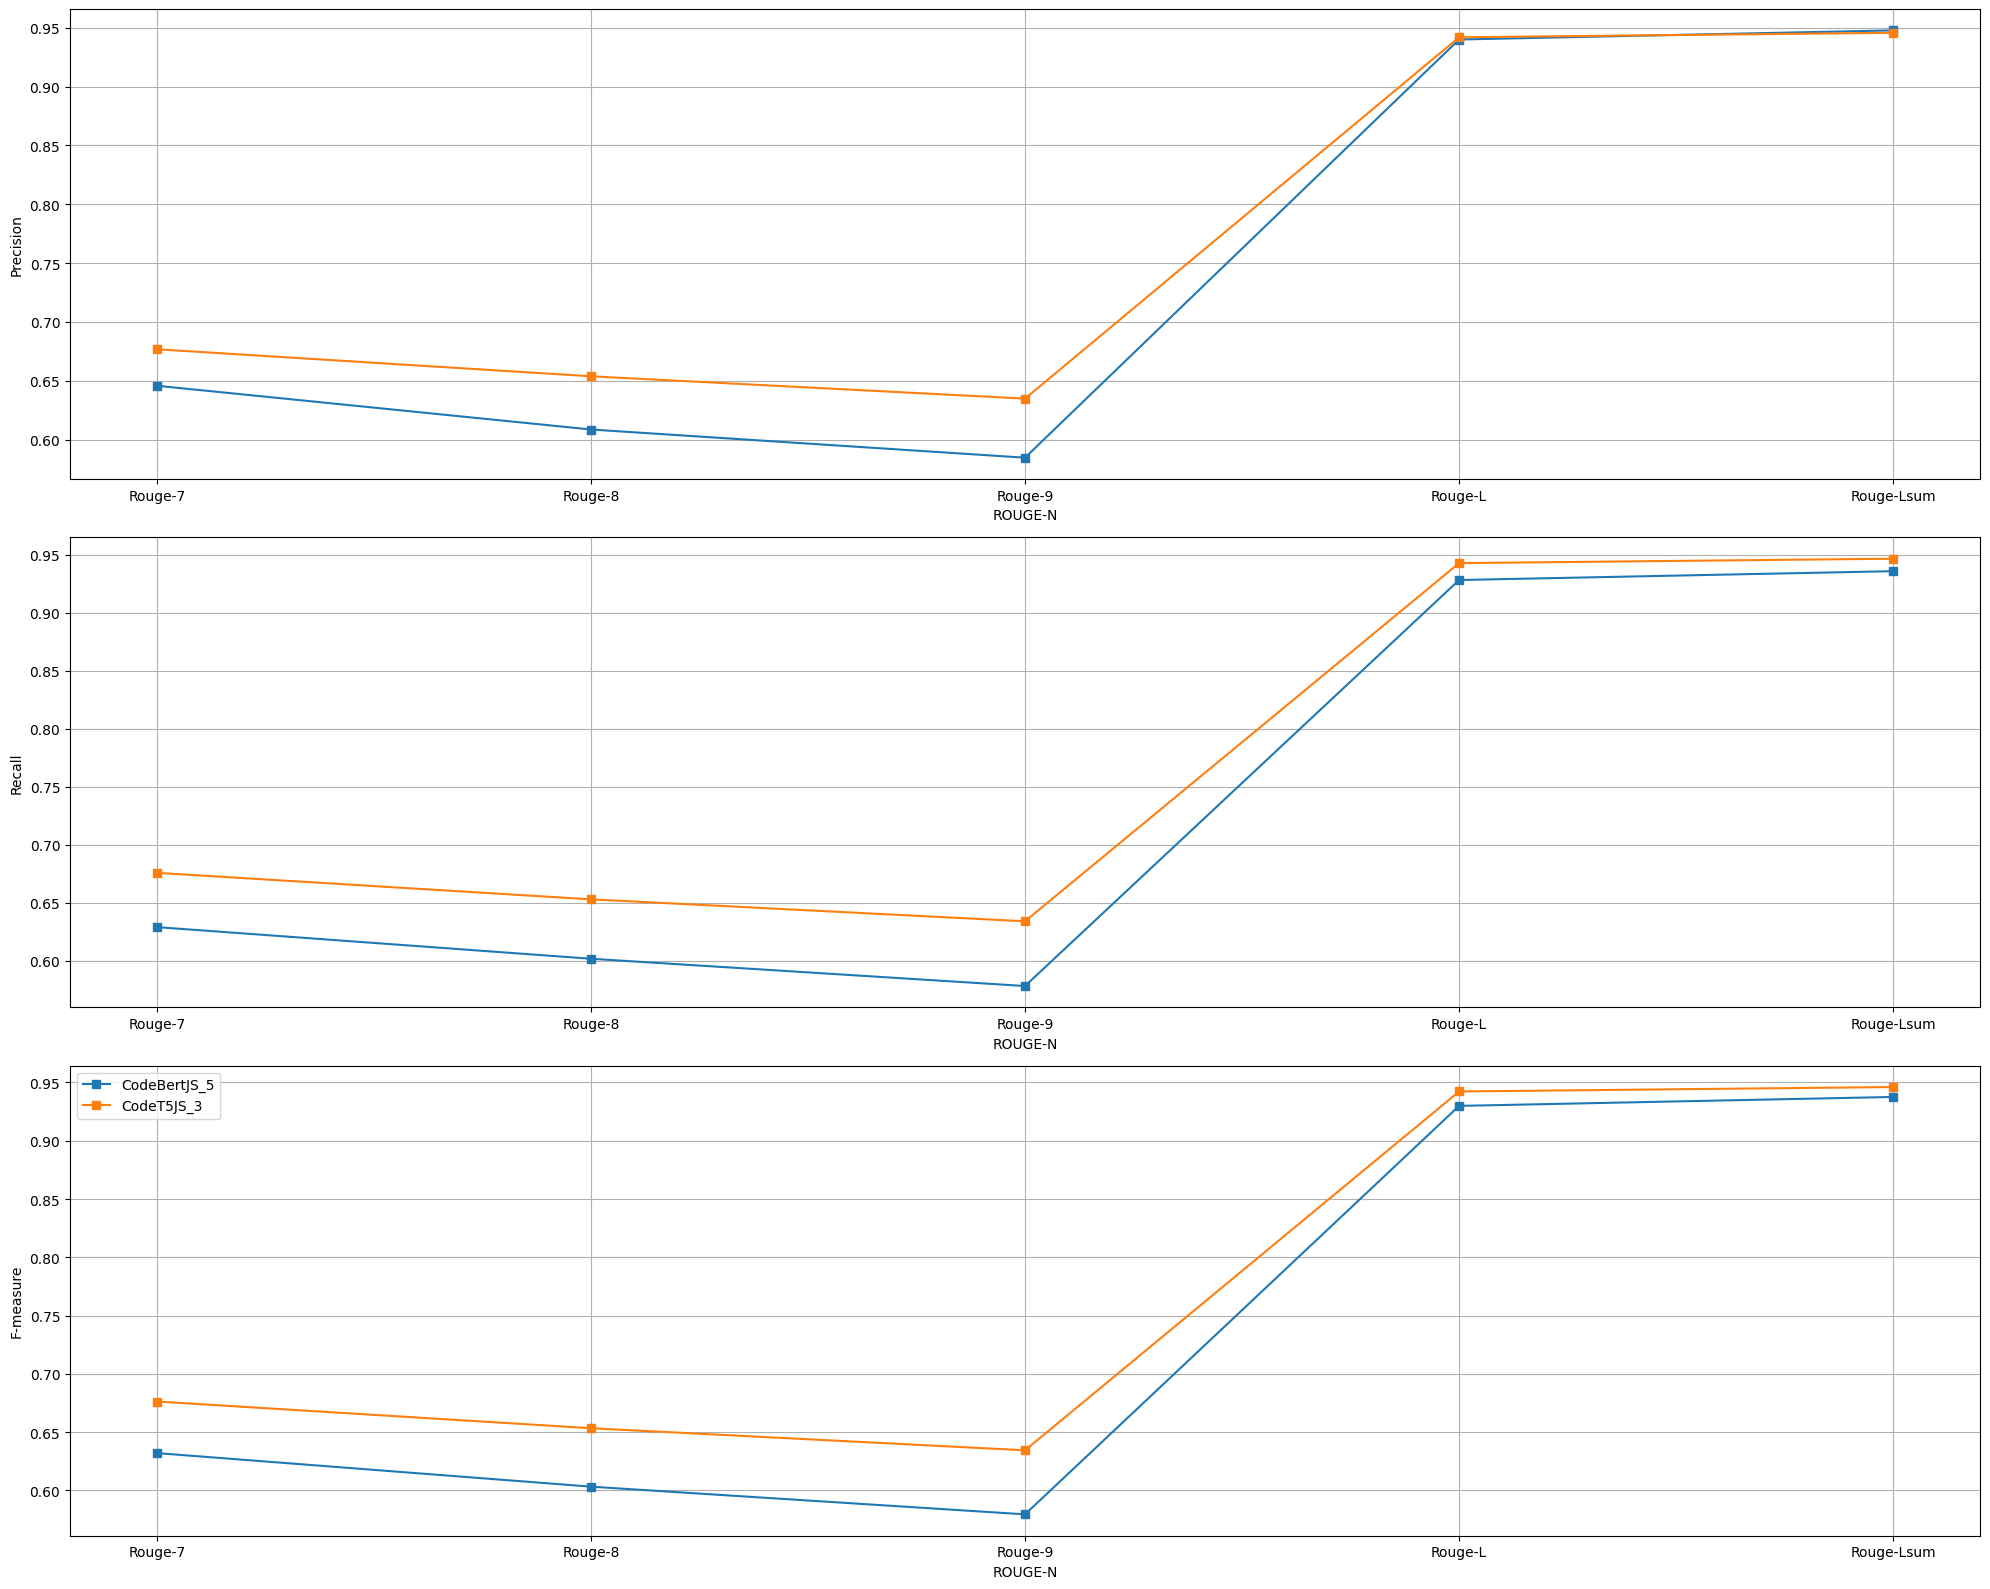

In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs  # Assuming rouge is a library/function that provides average scores

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-1].split('.')[0]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)

# Define metric types (assuming same metrics for both models)
metric_types = ('Rouge-7', 'Rouge-8', 'Rouge-9', 'Rouge-L', 'Rouge-Lsum')

# Create a figure with 3 rows (subplots) and 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16))

# Data dictionaries for each metric (assuming data structure from rouge)
precision_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].precision, codebert_avgs['avg_rouge8'].precision, codebert_avgs['avg_rouge9'].precision, codebert_avgs['avg_rougeL'].precision, codebert_avgs['avg_rougeLsum'].precision),
    comparison_model: (codet5_avgs['avg_rouge7'][0], codet5_avgs['avg_rouge8'][0], codet5_avgs['avg_rouge9'][0], codet5_avgs['avg_rougeL'][0], codet5_avgs['avg_rougeLsum'][0]),
}
recall_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].recall, codebert_avgs['avg_rouge8'].recall, codebert_avgs['avg_rouge9'].recall, codebert_avgs['avg_rougeL'].recall, codebert_avgs['avg_rougeLsum'].recall),
    comparison_model: (codet5_avgs['avg_rouge7'][1], codet5_avgs['avg_rouge8'][1], codet5_avgs['avg_rouge9'][1], codet5_avgs['avg_rougeL'][1], codet5_avgs['avg_rougeLsum'][1]),
}
f1_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].fmeasure, codebert_avgs['avg_rouge8'].fmeasure, codebert_avgs['avg_rouge9'].fmeasure, codebert_avgs['avg_rougeL'].fmeasure, codebert_avgs['avg_rougeLsum'].fmeasure),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}


# Plot Precision (ax1)
for model, precision in precision_data.items():
    ax1.plot(metric_types, precision, label=model, marker='s')  # 's' for square marker
ax1.set_xlabel('ROUGE-N')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Plot Recall (ax2)
for model, recall in recall_data.items():
    ax2.plot(metric_types, recall, label=model, marker='s')  # 'o' for circle marker
ax2.set_xlabel('ROUGE-N')
ax2.set_ylabel('Recall')
ax2.grid(True)

# Plot F1 Score (ax3)
for model, f1 in f1_data.items():
    ax3.plot(metric_types, f1, label=model, marker='s')
ax3.set_xlabel('ROUGE-N')
ax3.set_ylabel('F-measure')
ax3.grid(True)

plt.legend(loc='upper left')
plt.tight_layout()

# Save the entire figure as a single PNG
plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
ax